In [2]:
from dotenv import load_dotenv

import os

load_dotenv()

True

## Checando Tools 

Vamos importar as tools criadas anteriormente! 

In [3]:
from tools import *

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
trends = create_trends_tool()
trends_text = trends.invoke({"country": "brazil", 
                             "head": 3})
trends_list = to_list(trends_text)
trends_list

['Al-Hilal x Al-Fateh', 'Nintendo Switch 2', 'João Fonseca']

In [5]:
contents_news = get_serper_with_scrapping(trends_list, k=1)

100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


In [6]:
contents_news

{'Al-Hilal x Al-Fateh': [{'title': 'Palpite Al-Hilal x Al-Fateh – Campeonato Saudita – 16/01/2025',
   'link': 'https://br.bolavip.com/apostas/palpites/saudi-pro-league/palpite-al-hilal-x-al-fateh-campeonato-saudita-16-01-2025',
   'snippet': 'Palpite Al-Hilal x Al-Fateh pelo Campeonato Saudita. Análise, odds e palpites especiais do Bolavip para o jogo desta quinta-feira (16).',
   'date': 'há 10 horas',
   'source': 'Bolavip Brasil',
   'imageUrl': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT9Mz5buAL5buF-Wt-eRuvWHOkze27rB9_c4Cer19hc9wwDBix87ee59Oc&usqp=CAI&s',
   'position': 1,
   'content': 'Palpite Al-Hilal x Al-Fateh - Campeonato Saudita - 16/01/2025Tendências:Pablo é criticado pela NaçãoArrascaeta de saída do Fla?Novela Andreas Pereira tem vereditoSantos faz proposta por sueco Bruno Henrique ganha força no GaloJhon Arias no Palmeiras tem decisãoWanderson no Vasco tem reviravolta?BrasilBrasileirãoCopa do BrasilCampeonato PaulistaCampeonato CariocaSeleção BrasileiraAo Vi

## Construção do Agent

Para construir o agente, vamos utilizar as funções que construimos anteriormente. A ideia central é um agente que colete quais são as tendências de pesquisa no Google Trends, pesquise essas tendências no Google Api (SerpApi), faça scrapping dos resultados e crie uma newsletter com as informações. Para a construção desses fluxos, é comum fazermos o desenho do fluxo (que pode ser representado por um grafo).

<img src="../imgs/agent_trends.png" width="800">

Os componentes do agente são:

1. ``Estado``: é o objeto que irá armazenar as informações do agente ao longo do grafo.
2. ``Nós``: são as funções que irão realizar as ações do agente.
3. ``Transições (arestas)``: são as funções que irão decidir qual será o próximo nó a ser executado (ela pode ser condicional ou não).

### Estado do Grafo

In [7]:
from typing_extensions import TypedDict
from typing import List, Dict, Any

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        country: country of the trends
        head: number of trends to get
        k: number of news to get
        trends: list of trends
        news: dict of news about each trend
        newsletter: newsletter from the news
    """
    country: str
    head: int
    k: int
    trends: List[str]
    news: dict
    soccer_news: dict
    subjects: List[str] # New attribute
    favorite_team: str # New attribute
    newsletter: str

### Chains

Aqui definimos as cadeias de execução do agente. Normalmente separamos dessa forma pra que a construção dos nós fique mais organizada.

In [8]:

from operator import itemgetter
from typing import TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_openai import ChatOpenAI
# from langchain_groq import ChatGroq

def format_news(news: dict) -> str:
    """
    Format the news to be used in the newsletter.

    Args:
        news: dict of news about each trend

    Returns:
        str: formatted news
    """
    news_str = ""
    for trend, content in news.items():
        news_str += f"-----**{trend}**-----\n"
        for i, new in enumerate(content):
            title = new["title"]
            txt_content = new["content"]
            link = new["link"]
            
            news_str += f"""
            title: {title}
            link: {link}
            content: {txt_content}
            """
        news_str += "\n"
    return news_str

def write_newsletter(news: dict, 
                     provider: str="openai",
                     model_name: str="gpt-4o-mini",
                     temperature: float=0.2) -> str:
    """
    Generate a newsletter from the news.
    
    Args:
        news: dict of news about each trend
        provider: provider of the language model
        model_name: name of the language model
        temperature: temperature of the language model
        
    Returns:
        str: newsletter from the news
    """
    
    if provider == "openai": # Sugestão: gpt-4o-mini
        llm = ChatOpenAI(model=model_name, temperature=temperature)
    # elif provider == "groq": # Sugestão: llama-3.3-70b-versatile
    #     llm = ChatGroq(model=model_name, temperature=temperature)

    formatted_news = format_news(news)

    system_prompt = """
    Você é um assistente pessoal que vai escrever um newsletter sobre as notícias do dia que foram extraidas do Google Trends. Sua tarefa é resumir o conteúdo das notícias e escrever um texto informativo e interessante para o usuário. 
    
    Obs.: Sempre que possível, cite a fonte das notícias colocando o link de onde ela foi tirada.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Aqui está todo o conteúdo que você vai usar para fazer a newsletter: {input}"),
        ]
    )

    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke({"input": formatted_news})
    
    return response

## LLM Classifier Tool

In [9]:
from pydantic import BaseModel, Field
from typing import List

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

In [10]:
class GetSchema(BaseModel):
    """Schema de bolo"""
    
    resultado: str = Field(description="YES caso o texto fale de FUTEBOL e NO caso contrário", examples=['YES', 
                                                                                                        'NO'])

def llm_structured_extraction_classifier(model_name_openai = "gpt-4o-2024-08-06"):

    llm_openai = ChatOpenAI(
        model=model_name_openai,
        temperature=0,
    )

    system_prompt = """
        Você é um assistente de IA muito prestativo que vai auxiliar um jornalista a classificar textos que falam especificamente sobre FUTEBOL.
        Você precisa classificar o texto como YES ou NO, dependendo se o texto fala de futebol ou não.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt), 
            ("human", "query do usuário: \n\n {query}")
        ]
    )

    llm_openai_with_tools_extraction = llm_openai.bind_tools([GetSchema])
    chain_openai_structured_extraction = prompt | llm_openai_with_tools_extraction

    return chain_openai_structured_extraction

In [11]:
def classify_soccer_news(news: dict, 
                         model_name_openai = "gpt-4o-2024-08-06") -> dict:
    """
    Classify the news as soccer or not soccer.
    
    Args:
        news: dict of news about each trend
        model_name_openai: name of the language model
    """

    chain_openai_structured_extraction = llm_structured_extraction_classifier(model_name_openai)

    soccer_news = {}

    for trend, content in news.items():
        soccer_news[trend] = []
        for i, new in enumerate(content):
            # title = new["title"]
            txt_content = new["content"]
            # link = new["link"]
            
            response = chain_openai_structured_extraction.invoke({"query": txt_content})
            resultado = response.tool_calls[0]["args"]["resultado"]

            if resultado == "YES":
                soccer_news[trend].append(new)
    
    filtered_soccer_news = {k: v for k, v in soccer_news.items() if v}
    
    return filtered_soccer_news

## Send Email Tool

### Nodes

Aqui vamos definir os nós do grafo! Como dito anteriormente, entenda os nós como sendo funções a serem executadas. Cada entrada de um nó é a saída de um nó anterior, cada execução de nó podemos ou não modificar o estado do grafo (definido anteriormente).

In [12]:
from IPython.display import Markdown

def get_trends(state: GraphState) -> dict:
    """
    Get trends from Google Trends

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET TRENDS---")
    print()
    country = state["country"]
    head = state["head"]
    subjects = state["subjects"] # New attribute
    
    if subjects:
        print("--> Assuntos adicionais: ", subjects) # New print
 
    # Get trends
    trends = create_trends_tool()
    trends_text = trends.invoke({"country": country, 
                                 "head": head})
    trends_list = to_list(trends_text)
    
    print("Trend List: ", trends_list)
    print()
    
    return {"country": country, 
            "head": head, 
            "trends": trends_list}

def get_serper_and_scrapping(state: GraphState) -> dict:
    """
    Get news from SerpAPI and scrap the content

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET SERPER AND SCRAPPING---")
    print()
    trends = state["trends"]
    k = state["k"]
    subjects = state["subjects"] # New attribute
    
    # Get news
    news = get_serper_with_scrapping(queries=trends + subjects, k=k)
    keys_from_serper = news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(news[trend]))):
            print(news[trend][i]["title"])
        print()
    
    return {"news": news}

def filter_soccer_news(state: GraphState) -> dict:
    """
    Filter soccer news from the news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---FILTER SOCCER NEWS---")
    print()
    
    news = state["news"] # Get the news from GraphState that the previous node returned
    soccer_news = {}
    
    # Filter soccer news with tool
    soccer_news = classify_soccer_news(news)
    
    # Print some titles
    for trend, content in soccer_news.items():
        print(f"---{trend}---")
        for i in range(min(3, len(content))):
            print(content[i]["title"])
        print()
    
    return {"soccer_news": soccer_news}

def create_newsletter(state: GraphState) -> dict:
    """
    Create a newsletter from the news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """

    print("---CREATE NEWSLETTER---")
    print()
    news = state["soccer_news"]
    
    # Create newsletter
    newsletter = write_newsletter(news=news, 
                                  provider="openai",
                                  model_name="gpt-4o-mini",
                                  temperature=0.2)
    print("Aqui está a newsletter: ", newsletter)
    display(Markdown(newsletter))
    return {"newsletter": newsletter}

## Conditional Nodes

In [13]:
def search_favorite_team_news(state: GraphState) -> dict:
    """
    Search for the favorite team news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---SEARCH FAVORITE TEAM NEWS---")
    print()
    # news = state["news"]
    favorite_team = state["favorite_team"]
    k = state["k"]
    
    favorite_team_news = get_serper_with_scrapping(queries=[favorite_team], k=k)
    keys_from_serper = favorite_team_news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(favorite_team_news[trend]))):
            print(favorite_team_news[trend][i]["title"])
        print()
    
    return {"soccer_news": favorite_team_news}

In [14]:
def has_soccer_news(state: GraphState) -> str:
    """
    Check if there are soccer news

    Args:
        state (dict): The current graph state

    Returns:
        node (str): 
    """
    soccer_news = state["soccer_news"]

    return "create_newsletter" if soccer_news else "search_favorite_team_news"

## Email Node

In [ ]:
from email.message import EmailMessage
import ssl
import smtplib
from emails import EMAIL_SENDER, EMAIL_RECEIVERS

def send_email(state: GraphState):
    newsletter = state['newsletter']
    email_password = os.getenv("EMAIL_PASSWORD")

    subject = "Summer Nero 25 - Soccer Newsletter - Jonas"

    email_receiver = ", ".join(EMAIL_RECEIVERS)

    em = EmailMessage()
    em['From'] = EMAIL_SENDER
    em['To'] = email_receiver
    em['Subject'] = subject
    em.set_content(newsletter)

    context = ssl.create_default_context()

    with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smpt:
        smpt.login(EMAIL_SENDER, email_password)
        smpt.sendmail(EMAIL_SENDER, email_receiver, em.as_string())

### Workflow

Por fim, com os nós construidos e as cadeias definidas, podemos construir o workflow do agente.

In [16]:
from langgraph.graph import END, StateGraph

def compile_workflow():
    """ 
    Compiles the workflow for creating a newsletter from Google Trends.
    
    Returns:
        app (StateGraph): The compiled workflow.
    """
    
    # Define the graph
    workflow = StateGraph(GraphState)
    
    # Define the nodes
    workflow.add_node("get_trends", get_trends)
    workflow.add_node("get_serper_and_scrapping", get_serper_and_scrapping)
    workflow.add_node("filter_soccer_news", filter_soccer_news)
    workflow.add_node("search_favorite_team_news", search_favorite_team_news)
    workflow.add_node("create_newsletter", create_newsletter)
    workflow.add_node("send_email", send_email)

    # Build graph
    workflow.set_entry_point('get_trends')
    workflow.add_edge("get_trends", "get_serper_and_scrapping")
    workflow.add_edge("get_serper_and_scrapping", "filter_soccer_news")
    # workflow.add_edge("filter_soccer_news", "create_newsletter")
    
    workflow.add_conditional_edges(
        "filter_soccer_news",
        has_soccer_news,
        {
            "search_favorite_team_news": "search_favorite_team_news",
            "create_newsletter": "create_newsletter"
        },
    )

    workflow.add_edge("search_favorite_team_news", "create_newsletter")
    
    workflow.add_edge("create_newsletter", "send_email")
    workflow.add_edge("send_email", END)
    # workflow.set_finish_point("create_newsletter")

    # Compile
    app = workflow.compile()
    return app

In [17]:
app = compile_workflow()

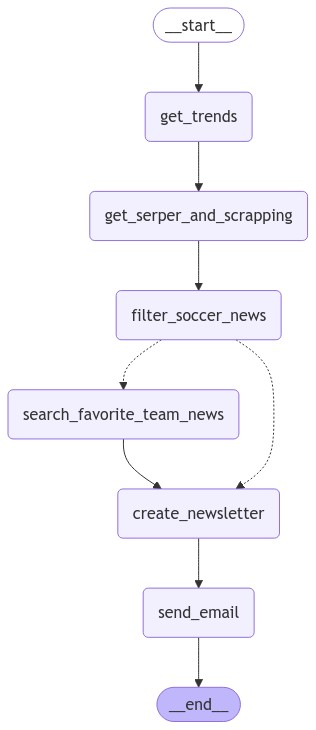

In [18]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [19]:
response = app.invoke({"country": "brazil",
                       "head": 1,
                       "subjects": [],
                       "favorite_team": "Flamengo",
                       "k": 3})

---GET TRENDS---

Trend List:  ['Al-Hilal x Al-Fateh']

---GET SERPER AND SCRAPPING---



100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


---Al-Hilal x Al-Fateh---
Palpite Al-Hilal x Al-Fateh – Campeonato Saudita – 16/01/2025
Al-Hilal goleia o Al-Fateh pelo Campeonato Saudita com três gols de Marcos Leonardo
Neymar joga hoje? Saiba o panorama para Al-Hilal x Al-Fateh

---FILTER SOCCER NEWS---

---Al-Hilal x Al-Fateh---
Palpite Al-Hilal x Al-Fateh – Campeonato Saudita – 16/01/2025
Al-Hilal goleia o Al-Fateh pelo Campeonato Saudita com três gols de Marcos Leonardo
Neymar joga hoje? Saiba o panorama para Al-Hilal x Al-Fateh

---CREATE NEWSLETTER---

Aqui está a newsletter:  **Newsletter do Dia - 16 de Janeiro de 2025**

Olá, leitores! Hoje trazemos as principais notícias do mundo do futebol, com destaque para o Campeonato Saudita, onde o Al-Hilal teve uma atuação impressionante.

### Al-Hilal Goleia Al-Fateh

O Al-Hilal não teve piedade e goleou o Al-Fateh por 9 a 0 em uma partida que ficará marcada na história do Campeonato Saudita. O destaque da partida foi o atacante Marcos Leonardo, que marcou três gols. Outros jogadore

**Newsletter do Dia - 16 de Janeiro de 2025**

Olá, leitores! Hoje trazemos as principais notícias do mundo do futebol, com destaque para o Campeonato Saudita, onde o Al-Hilal teve uma atuação impressionante.

### Al-Hilal Goleia Al-Fateh

O Al-Hilal não teve piedade e goleou o Al-Fateh por 9 a 0 em uma partida que ficará marcada na história do Campeonato Saudita. O destaque da partida foi o atacante Marcos Leonardo, que marcou três gols. Outros jogadores que contribuíram para a vitória foram Koulibaly, Renan Lodi, Milinkovic-Savic, Al-Hamdan, Malcom e um gol contra de Al Abdulwahed. Com essa vitória, o Al-Hilal se mantém firme na liderança da competição, agora com 40 pontos. Para mais detalhes, acesse a matéria completa [aqui](https://ge.globo.com/futebol/futebol-internacional/noticia/2025/01/16/al-hilal-goleia-o-al-fateh-pelo-campeonato-saudita-com-tres-gols-de-marcos-leonardo.ghtml).

### Palpite para Al-Hilal x Al-Fateh

Antes da goleada, o jogo foi analisado por especialistas que previam uma vitória contundente do Al-Hilal, dada a disparidade entre as equipes. As odds indicavam um handicap asiático de -2.75 para o Al-Hilal, e a expectativa era de mais de 3.5 gols na partida. O Al-Hilal, jogando em casa, tinha um histórico impressionante, vencendo todas as partidas em seu estádio até então. Confira a análise completa e as odds [neste link](https://br.bolavip.com/apostas/palpites/saudi-pro-league/palpite-al-hilal-x-al-fateh-campeonato-saudita-16-01-2025).

### Neymar Fora de Combate

Em meio a toda a ação, a situação de Neymar continua a ser um tópico de interesse. O atacante brasileiro não participou da partida contra o Al-Fateh e não deve voltar a jogar pelo Al-Hilal tão cedo, devido a lesões recorrentes. Desde sua última aparição em novembro de 2024, Neymar não foi escalado e está fora dos planos para o Campeonato Saudita, podendo retornar apenas em fevereiro para a Champions League Saudita. Para mais informações sobre o estado de Neymar, clique [aqui](https://www.lance.com.br/futebol-internacional/neymar-joga-hoje-saiba-o-panorama-para-al-hilal-x-al-fateh.html).

Fique ligado para mais atualizações e análises sobre o mundo do futebol!

## Conclusão:

Com essa aplicação simples é possível ver como podemos construir um agente que coleta informações de tendências de pesquisa e cria uma newsletter. Para além dessa ideia, é possível construir aplicações mais robustas, que envolvem ``novos nós, novas cadeias, novos estados ou até transições condicionais``. 

### Tarefa de casa:

1. Crie um novo nó que envie a newsletter por email. Note que para isso você precisa incluir uma lista de emails que irão receber a newsletter. (``Dica:`` Faça a lista de emails ser um parâmetro na entrada do grafo, assim você pode passar a lista de emails como parâmetro para o nó que envia a newsletter).

2. Calcule quanto custa em média uma newsletter. (``Dica:`` Use o LangSmith).

3. Construa um classificador que classifica as notícias de acordo com o assunto. Especificamente, classifique se a notícia fala sobre futebol ou não (``binário``). No fim, faça a newsletter somente baseada em assuntos de futebol (seu classificador será um filtro).

4. Crie um ``conditional_edge`` que verifica se existe noticia ou não de futebol. Caso não tenha noticias de futebol no Google Trends, crie um nó que vai pesquisar sobre seu time de futebol favorito e adicione na newsletter apenas os ultimos assuntos dele.

5. Crie uma ``API`` (com ``FastAPI``, por exemplo), que contenha um endpoint que recebe:

```python
{"country": "brazil",
 "head": 5,
 "k": 3}
 ```

E devolve o estado do grafo.